# Import libraries

In [1]:
#! pip install holidays
import pandas as pd
import numpy as np

from collections import Counter
import holidays
import sys


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Append path
#sys.path += ['./feature_extraction', './utils', '../src']
sys.path += ['../src']
from feature_engineering import *
from feature_scaling import *
from outliers import *
from utils import *
from helperFunctions import *

# Full data preprocesssing pipeline

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
./feature_extraction/feature_engineering.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

<class 'pandas.core.frame.DataFrame'>


/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


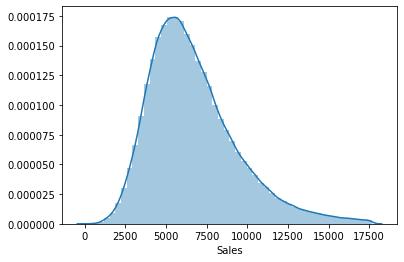

In [3]:
# 1. Load input
train = pd.read_csv("../data/train.csv")
store = pd.read_csv("../data/store.csv")


# 2. Check for weird Sales entries
train2 = closed_sales(train)
#not_open_but_nonzerosales = (train2.Open == 0) & (train2.Sales != 0)
#not_open_but_nonzerosales.sum() / len(train) * 100


# 3. Remove zero Sales
nonzero_sales = remzero_sales(train2, col='Sales')
nonzero_sales.shape

# 4. convert date column
nonzero_sales = convert_date(nonzero_sales, col='Date')
#nonzero_sales.info()

# 5. Feature Engineering 1: date time features
nonzero_sales = date_converter(nonzero_sales, col='Date')
#nonzero_sales.head()

# 6. Feature engineering 2: Sales per customer
nonzero_sales = sales_percust(nonzero_sales, by='Store', col1='Sales', col2='Customers')
#nonzero_sales.isnull().sum()

# 7. Feature engineering 3: Customer per Store
nonzero_sales = cust_perstore(nonzero_sales, by='Store', col='Customers')

# 8. Merge train and store dataset
merged_train_store = merge_df(store, nonzero_sales, col='Store')
#merged_train_store.info()

# 9. CompYear Outlier removal
merged_train_store = comp_outliers(merged_train_store, yr='CompetitionOpenSinceYear')
#merged_train_store.CompetitionOpenSinceYear.plot(kind='hist')

# 10. Remove missing promo
merged_train_store = drop_napromo(merged_train_store, p1='Promo', p2='Promo2')
#merged_train_store.isnull().sum() / len(merged_train_store) * 100

# 11. Mean impute CompetitionOpenSinceMonth/Year
merged_train_store = mean_imputation(merged_train_store,['CompetitionOpenSinceMonth', 
                                                         'CompetitionOpenSinceYear'])
#merged_train_store.isnull().sum() / len(merged_train_store) * 100

# 12*. Constant and mean impute Promo2SinceWeek/Year
Promo2 = merged_train_store.Promo2 == 0

merged_train_store.loc[Promo2] = const_imputation(merged_train_store.loc[Promo2],
                                                    ['Promo2SinceWeek', 'Promo2SinceYear'],
                                                    values=0)

merged_train_store.loc[~Promo2] = mean_imputation(merged_train_store.loc[~Promo2],
                                                    ['Promo2SinceWeek', 'Promo2SinceYear'],
                                                    enforce_int=True)

# 13. Constant impute PromoInterval
merged_train_store = const_imputation(merged_train_store,['PromoInterval'],values='unavailable')
#merged_train_store.isnull().sum() / len(merged_train_store) * 100

# 14. Drop rows with missing 'Sales' in case 'Open' or 'Customers' is zero
merged_train_store = dropnasales_ifopen(merged_train_store, drop='Sales')
#merged_train_store.isnull().sum() / len(merged_train_store) * 100

# 15. Impute the missing Sales
merged_train_store = impute_sales(merged_train_store)
#merged_train_store.isnull().sum()

# 16. Impute State Holidays
merged_train_store = impute_holiday(merged_train_store)
#merged_train_store.isnull().sum() / len(merged_train_store) * 100

# 17. Drop the customer column
merged_train_store = drop_cust(merged_train_store, cols=['Customers'])
#merged_train_store.isnull().sum() / len(merged_train_store) * 100

# 18*. Drop nans from CompetitionDistance, Open, SchoolHoliday
merged_train_store = drop_na(merged_train_store, cols=['Open', 'SchoolHoliday', 'CompetitionDistance'])
#merged_train_store.shape

# 19. Feature engineering 4: mean encode Store
merged_train_store = groupby_meanenc(merged_train_store, by='Store', on='Sales')
#merged_train_store.head()

# 20. Feature engineering 5: OHE StoreType, PromoInterval
merged_train_store = onehot(merged_train_store, cols=['StoreType', 'PromoInterval'])
#merged_train_store.head()

# 21. Feature engineering 6: Ordinal encoding Assortment
merged_train_store = ordinal_enc(merged_train_store, col='Assortment')

# 22*. Feature engineering 7: Categorize CompetitionDistance
merged_train_store = compdist_cat(merged_train_store, q=3)
#merged_train_store.head()

# 23. Feature engineering 8: CompetitionOpenSincePeriod
merged_train_store = compet_openmonths(merged_train_store, yr='CompetitionOpenSinceYear', mth='CompetitionOpenSinceMonth')
#merged_train_store.info()

# 24. Feature engineering 9: Promo2Since how many weeks
merged_train_store = promo_openweeks(merged_train_store, yr='Promo2SinceYear', week='Promo2SinceWeek')
#merged_train_store.info()

# 25. Feature engineering 10: Binarize stateholidays
merged_train_store = holi_binarizer(merged_train_store)

# 26. Remove outliers from Sales
merged_train_store = drop_outlier(merged_train_store, col='Sales', per=99)
sns.distplot(merged_train_store.Sales)

# Train test split

In [4]:
X = merged_train_store.drop(['Sales', 'Date'], axis=1)
y = merged_train_store.Sales

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119b81910>,
      dtype=object)

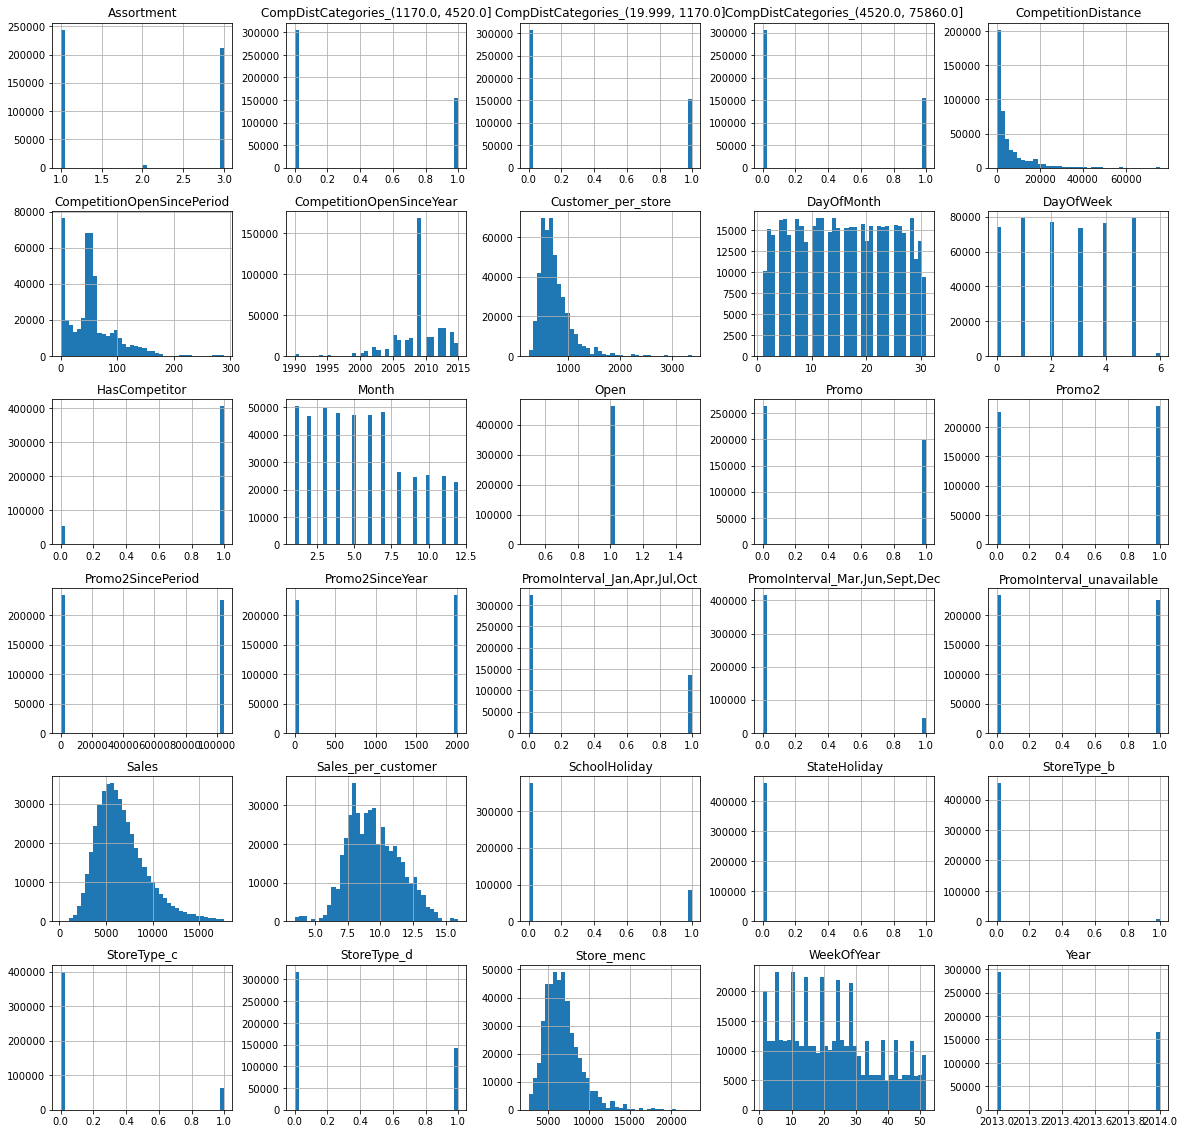

In [6]:
merged_train_store.hist(figsize=[20,20], bins=40)

#### Feature Selection

In [7]:
my_features = ['Sales_per_customer', 'CompetitionDistance', 'Customer_per_store', 
               'Store_menc', 'CompetitionOpenSincePeriod', 
               'Month', 'Year', 'DayOfWeek', 'WeekOfYear', 'DayOfMonth', 
               'StoreType_b', 'StoreType_c', 'StoreType_d', 
               'Promo2SincePeriod', 'Promo2', 'Promo', 
               'HasCompetitor', 'CompetitionOpenSincePeriod', 
               'Assortment', 'CompetitionDistance']

#### Feature scaling transformer

In [8]:
minmax_cols, rob_cols, std_cols = feature_selector(my_features)

In [10]:
ct = feature_transformer(minmax_cols, rob_cols, std_cols)

# Dimensionality Reduction

<BarContainer object of 5 artists>

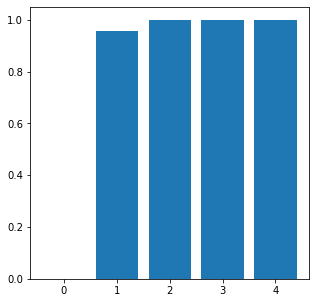

In [19]:
# Unscaled features
summed_evr = dict()

for i in range(5):
    pca = PCA(n_components=i)
    fit_pca = pca.fit_transform(X_train.loc[:, my_features])
    summed_evr.update({i : sum(pca.explained_variance_ratio_)})
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.bar(summed_evr.keys(), summed_evr.values())

<BarContainer object of 5 artists>

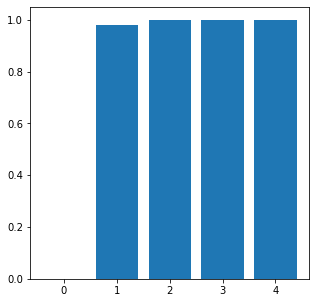

In [21]:
# Unscaled features
summed_evr = dict()

for i in range(5):
    pca = PCA(n_components=i)
    X_scaled = ct.fit_transform(X_train.loc[:, my_features])
    fit_pca = pca.fit_transform(X_scaled)
    summed_evr.update({i : sum(pca.explained_variance_ratio_)})
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.bar(summed_evr.keys(), summed_evr.values())

# Modelling

In [11]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

#### Random Forest

In [23]:
rf = RandomForestRegressor(n_estimators=100, 
                           min_samples_leaf=3, 
                           max_depth=5, 
                           random_state=42)

pca = PCA(n_components=2)


steps = [('scaler', ct), ('rf', rf)]

pipe = Pipeline(steps)

pipe.fit(X_train.loc[:, my_features], y_train)

y_pred = pipe.predict(X_test.loc[:, my_features])

rf_base_metric = metric(y_pred, y_test.values)

print("Metric for baseline prediction = {}".format(rf_base_metric))

Metric for baseline prediction = 25.359650442413937


###### RandomForest Grid Search

In [25]:
# Define  estimator
rf = RandomForestRegressor(random_state=42)

# Define Pipeline
steps = [('scaler', ct), ('rf', rf)]

pipe = Pipeline(steps)

# Implement GridSearch
params_rf = {'rf__n_estimators' : [50, 100, 150, 200,], 
              'rf__max_depth':np.arange(2,5),  
              'rf__min_samples_leaf':np.arange(2,5), 
              }

rs_rf = RandomizedSearchCV(pipe, 
                           param_distributions=params_rf, 
                           n_iter=12, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, 
                           cv=5, 
                           random_state=42, 
                           verbose=2)

rs_rf.fit(X_train.loc[:, my_features], y_train)

# Prection accuracy
y_pred = rs_rf.predict(X_test.loc[:, my_features])

rf_base_metric = metric(y_pred, y_test.values)

print("Metric for baseline prediction = {}".format(rf_base_metric))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 55.2min finished


Metric for baseline prediction = 26.561745195345075


#### Lasso

In [14]:
lasso = Lasso(alpha=0.1)

steps = [('scaler', ct), ('lasso', lasso)]

pipe = Pipeline(steps)

pipe.fit(X_train.loc[:, my_features], y_train)

y_pred = pipe.predict(X_test.loc[:, my_features])

rf_base_metric = metric(y_pred, y_test.values)

print("Metric for baseline prediction = {}".format(rf_base_metric))

Metric for baseline prediction = 24.957296840676626


###### Lasso Grid Search

In [27]:
# Define  estimator
lasso = Lasso(random_state=42)

# Define Pipeline
steps_las = [('scaler', ct), ('lasso', lasso)]

pipe_las = Pipeline(steps_las)

# Implement GridSearch
params_las = {'lasso__alpha' : [0.001, 0.01, 0.1, 1.]
              }

rs_las = RandomizedSearchCV(pipe_las, 
                           param_distributions=params_las, 
                           n_iter=4, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, 
                           cv=5, 
                           random_state=42, 
                           verbose=2)

rs_las.fit(X_train.loc[:, my_features], y_train)

# Prection accuracy
y_pred_las = rs_las.predict(X_test.loc[:, my_features])

las_base_metric = metric(y_pred_las, y_test.values)

print("Metric for baseline prediction = {}".format(las_base_metric))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.7min finished


Metric for baseline prediction = 24.960909614742455


/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365286467885.59235, tolerance: 275121333.2778802
  model = cd_fast.enet_coordinate_descent(


#### XGBoost

In [15]:
xgbreg = xgb.XGBRegressor(random_state=42, 
                          objective='reg:squarederror', 
                          booster='gbtree', 
                          gamma=0.01, 
                          learning_rate=0.1, 
                          max_depth=4, 
                          n_estimators=120, 
                          reg_alpha=0.001, 
                          reg_lambda=0.25)



steps = [('scaler', ct), ('xgb', xgbreg)]

pipe = Pipeline(steps)

pipe.fit(X_train.loc[:, my_features], y_train)

y_pred = pipe.predict(X_test.loc[:, my_features])

rf_base_metric = metric(y_pred, y_test.values)

print("Metric for baseline prediction = {}".format(rf_base_metric))

Metric for baseline prediction = 19.766446796103512


###### XGBoost Regressor Grid Search

In [28]:
# Define  estimator
xgbreg = xgb.XGBRegressor(random_state=42, 
                          objective='reg:squarederror',
                          booster='gbtree',
                          reg_lambda=0.25
                         )

# Define Pipeline
steps_xgb = [('scaler', ct), ('xgb', xgbreg)]

pipe_xgb = Pipeline(steps_xgb)

# Implement GridSearch
params_xgb = {'xgb__n_estimators' : [50, 100, 150, 200,], 
              'xgb__max_depth': np.arange(3, 6),  
              'xgb__learning_rate' : [0.001, 0.01, 0.1],
              'xgb__gamma' : [0.01, 0.1], 
              'xgb__reg_alpha' : np.logspace(-3, 3, 6),
              }

rs_xgb = RandomizedSearchCV(pipe_xgb, 
                           param_distributions=params_xgb, 
                           n_iter=12, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, 
                           cv=5, 
                           random_state=42, 
                           verbose=2)

rs_xgb.fit(X_train.loc[:, my_features], y_train)

# Prection accuracy
y_pred_xgb = rs_xgb.predict(X_test.loc[:, my_features])

xgb_base_metric = metric(y_pred_xgb, y_test.values)

print("Metric for baseline prediction = {}".format(xgb_base_metric))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 46.3min finished


Metric for baseline prediction = 18.01762697837448
